In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap 
import json 
import xgboost
import seaborn as sns
import math

/Users/daniel/miniconda3/envs/graphworld/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def df_gen(RESULTS_DIR, NSHARDS = 10):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [119]:
NSHARDS = 10
models = ['HGCN', 'GCN']
RESULTS_DIR = '../../graph_gen/snellius_gen/rq3/both_flat/both_flat'

dfs = []
for i in range(1,7):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)


df = pd.concat(dfs, axis = 0)
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,HGCN__model_c,HGCN__model_dropout,HGCN__model_hidden_channels,HGCN__model_in_channels,HGCN__model_lr,HGCN__model_num_layers,HGCN__model_weight_decay,HGCN__model_out_channels,HGCN__train_epochs,HGCN__train_patience
0,1824,2.252386,0.638524,16,1.0,1,3.540545,2,0.237937,2.256277,...,NaN,0.4,16,16,0.0020,1,0.0000,2,200,20
1,3508,20.237741,1.594181,16,1.0,1,4.770776,7,0.849316,2.828074,...,2.0,0.0,32,16,0.0010,3,0.0010,7,200,20
2,1805,15.114809,0.950333,16,1.0,1,7.372439,4,0.781346,2.829428,...,1.0,0.2,16,16,0.0005,3,0.0005,4,200,20
3,4059,11.163747,0.557918,16,1.0,1,14.668920,6,0.196366,1.130775,...,NaN,0.0,32,16,0.0005,3,0.0000,6,200,20
4,3616,30.416195,1.308150,16,1.0,1,7.924338,2,0.522677,1.196503,...,2.0,0.0,16,16,0.0005,1,0.0000,2,200,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,3038,5.714286,1.312760,16,1.0,1,13.952611,7,0.192738,1.890825,...,2.0,0.4,32,16,0.0020,2,0.0005,7,200,20
2996,3365,12.142304,1.522117,16,1.0,1,10.089641,8,0.794868,2.864627,...,NaN,0.0,16,16,0.0020,2,0.0010,8,200,20
2997,1503,15.034806,1.528538,16,1.0,1,3.655558,7,0.735972,2.161818,...,1.0,0.0,32,16,0.0010,1,0.0000,7,200,20
2998,2246,18.915594,1.667150,16,1.0,1,9.908317,7,0.526982,1.431817,...,2.0,0.0,16,16,0.0010,3,0.0010,7,200,20


In [42]:
df[[f'{model}__test_rocauc_ovr' for model in models]].describe()

,HGCN__test_rocauc_ovr,GCN__test_rocauc_ovr
count,2999.000000,3000.000000
mean,0.795864,0.835507
std,0.189287,0.134858
min,0.000000,0.008872
25%,0.644497,0.751978
50%,0.866039,0.863601
75%,0.956218,0.949573
max,1.000000,1.000000


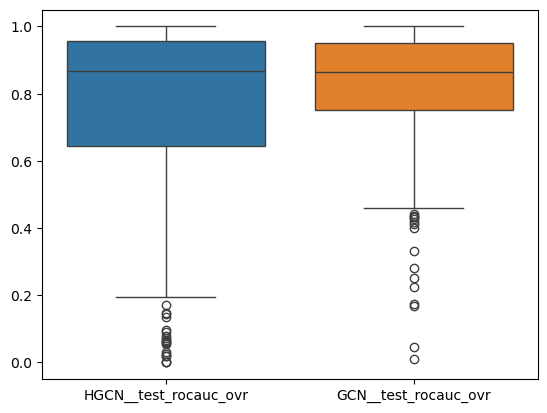

In [44]:
sns.boxplot(df[[f'{model}__test_rocauc_ovr' for model in models]])
plt.show()

In [120]:
perf_meas = "test_rocauc_ovr"
df['perf_delta'] = df[f'GCN__{perf_meas}']-df[f'HGCN__{perf_meas}']

graph_metrics_refined = ['nvertex', 'avg_degree', 'degree_gini', 'p_to_q_ratio',
                 'num_clusters', 'community_size_simpsons', 'feature_center_distance',
                 'avg_cc', 'power_law_estimate']

graph_metrics_computable = ['nvertex', 'avg_degree', 'degree_gini', 'edge_homogeneity',
                 'num_clusters', 'community_size_simpsons', 'feature_angular_snr',
                 'avg_cc']

graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

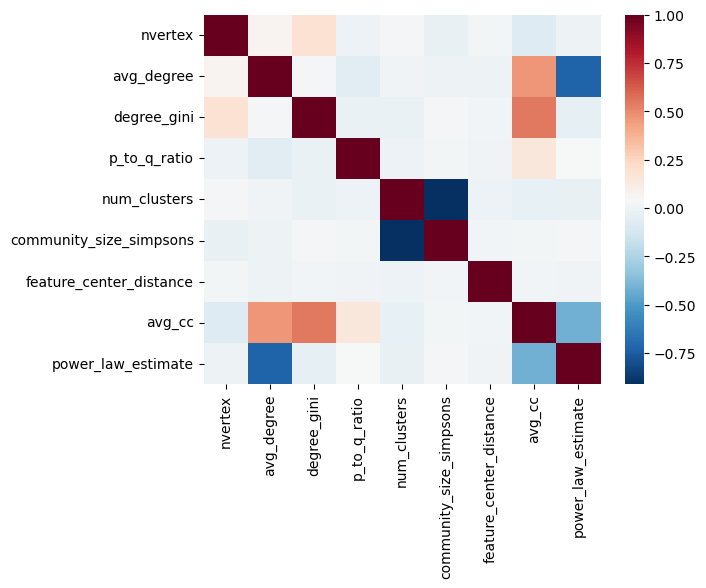

In [65]:
sns.heatmap(df[graph_metrics_refined].corr(),
            yticklabels=True,
            xticklabels=True,
            cmap="RdBu_r")
plt.show()

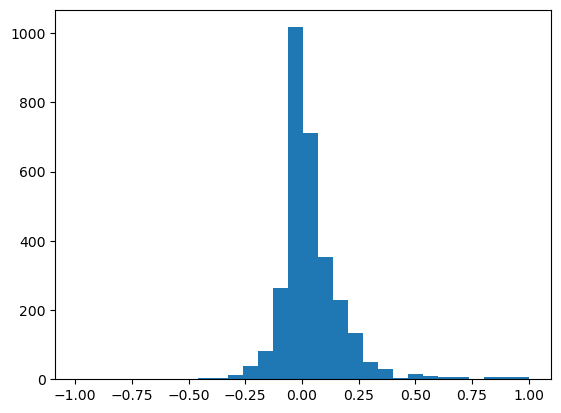

In [66]:
plt.hist(df['perf_delta'], bins  = 30)
plt.show()

----- Running Pre-flight Data Checks -----
NaN values found in columns:
 Series([], dtype: int64)

Infinity values found in columns:
 Series([], dtype: int64)

Dropped 0 rows containing NaN or infinity values.
------------------------------------------

Training data shape: (2399, 31)
Testing data shape: (600, 31)

----- Training XGBoost Model -----
Model training complete.

----- Model Evaluation on Test Data -----
Mean Squared Error (MSE): 0.0154
R-squared (R²): 0.1159
R² indicates the proportion of variance in the target that is predictable from the features.
-----------------------------------------

----- Feature Importance Analysis -----


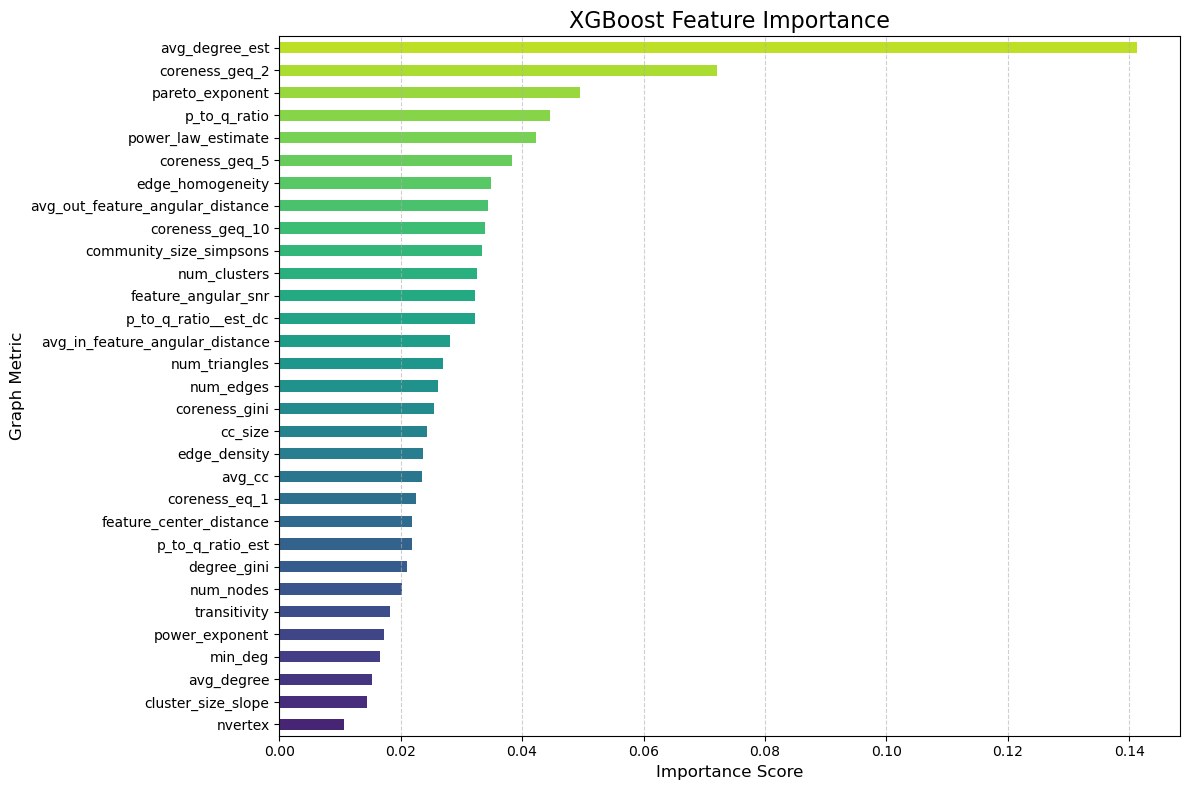

In [102]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print("----- Running Pre-flight Data Checks -----")
# Check for NaN values
nan_counts = df[graph_metrics + ['perf_delta']].isnull().sum()
print("NaN values found in columns:\n", nan_counts[nan_counts > 0])

# Check for infinity values
inf_counts = df[graph_metrics + ['perf_delta']].apply(lambda col: np.isinf(col).sum())
print("\nInfinity values found in columns:\n", inf_counts[inf_counts > 0])

# Store original size to see how many rows are dropped
original_size = len(df)

# Remove rows with any NaN or infinity values in the relevant columns
# Replace infinity with NaN, then drop all NaNs. This handles both cases.
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=graph_metrics + ['perf_delta'], inplace=True)

print(f"\nDropped {original_size - len(df)} rows containing NaN or infinity values.")
print("-" * 42 + "\n")

X = df[graph_metrics]
y = df['perf_delta']

# Split the data into training and testing sets (80% train, 20% test)
# This is crucial for evaluating how well the model generalizes to new, unseen data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}\n")


# --- 2. Train the XGBoost Regressor Model ---
# Instantiate the model with common hyperparameters
# n_estimators: number of boosting rounds
# max_depth: maximum depth of a tree
# learning_rate: step size shrinkage
# objective: defines the loss function to be minimized
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Train the model on the training data
print("----- Training XGBoost Model -----")
xgbr.fit(X_train, y_train)
print("Model training complete.\n")


# --- 3. Evaluate the Model's Performance ---
# Make predictions on the test set
y_pred = xgbr.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("----- Model Evaluation on Test Data -----")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("R² indicates the proportion of variance in the target that is predictable from the features.")
print("-" * 41 + "\n")


# --- 4. Analyze and Visualize Feature Importance ---
print("----- Feature Importance Analysis -----")
# Get feature importance scores from the trained model
feature_importances = pd.Series(xgbr.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=True)

# Create a horizontal bar plot for better readability
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='barh', color=plt.cm.viridis(np.linspace(0.1, 0.9, len(feature_importances))))
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Graph Metric', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to make room for labels
plt.show()

Number of overall samples: 2999
Number of samples where HGCN is better by .1: 506
----- Analyzing Metric: nvertex -----


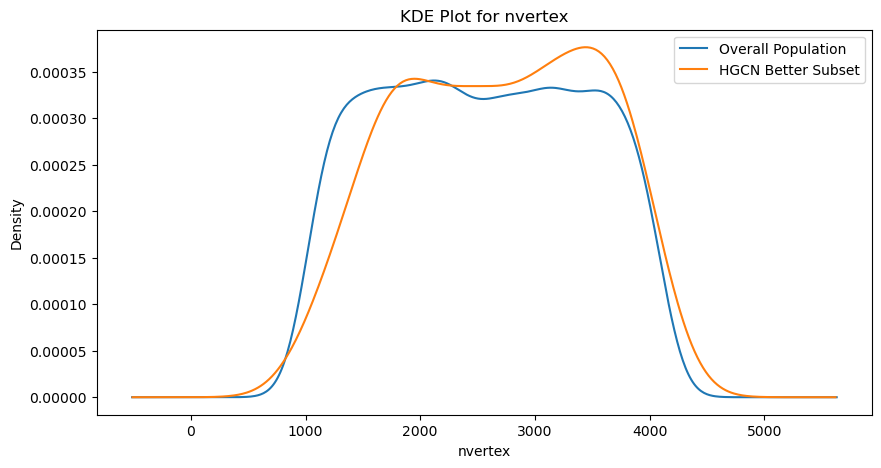

K-S Statistic: 0.0909
P-value: 0.0604
Conclusion: We cannot conclude the distributions are different (p >= 0.05). ❌
------------------------------------

----- Analyzing Metric: avg_degree -----


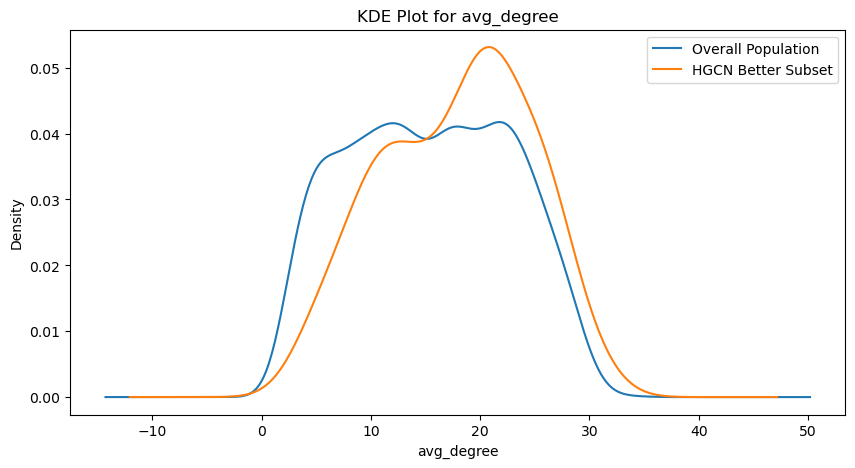

K-S Statistic: 0.1493
P-value: 0.0002
Conclusion: The distributions are significantly different (p < 0.05). ✅
---------------------------------------

----- Analyzing Metric: degree_gini -----


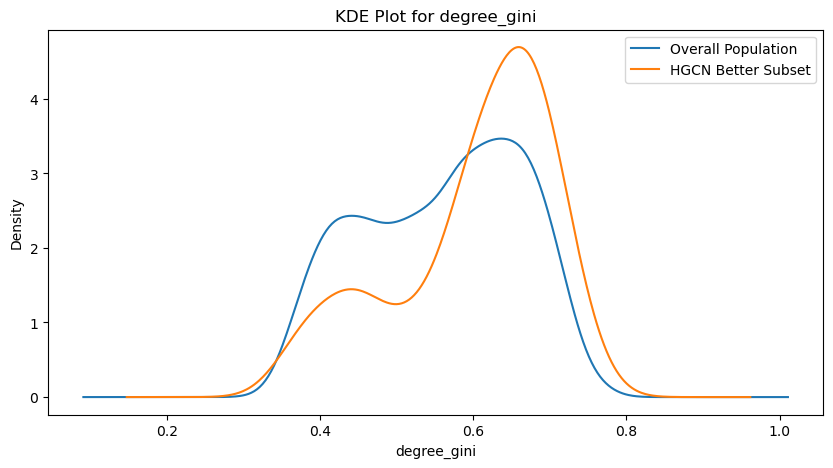

K-S Statistic: 0.2205
P-value: 0.0000
Conclusion: The distributions are significantly different (p < 0.05). ✅
----------------------------------------

----- Analyzing Metric: p_to_q_ratio -----


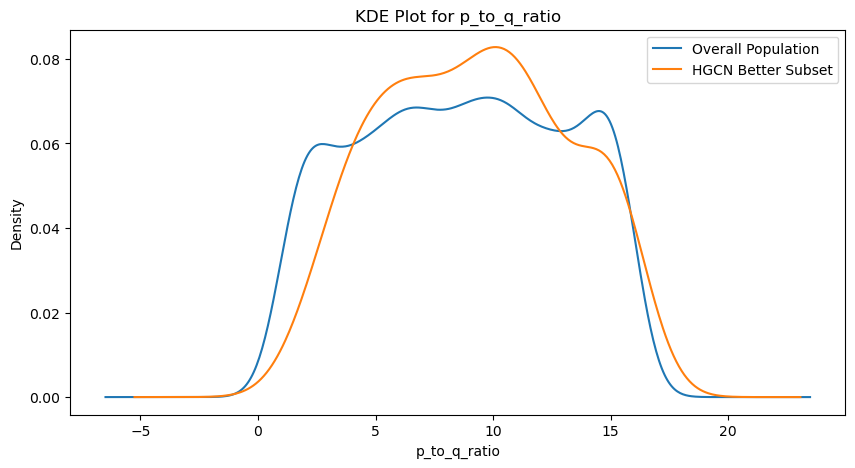

K-S Statistic: 0.0956
P-value: 0.0418
Conclusion: The distributions are significantly different (p < 0.05). ✅
-----------------------------------------

----- Analyzing Metric: num_clusters -----


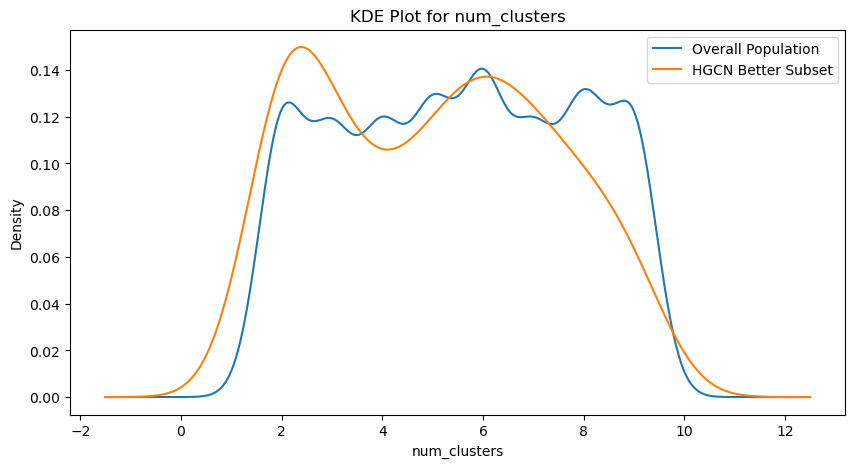

K-S Statistic: 0.0944
P-value: 0.0462
Conclusion: The distributions are significantly different (p < 0.05). ✅
-----------------------------------------

----- Analyzing Metric: community_size_simpsons -----


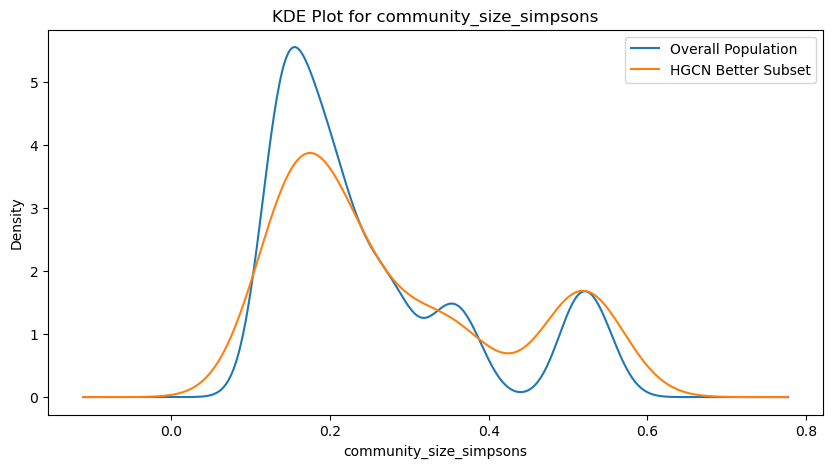

K-S Statistic: 0.0982
P-value: 0.0339
Conclusion: The distributions are significantly different (p < 0.05). ✅
----------------------------------------------------

----- Analyzing Metric: feature_center_distance -----


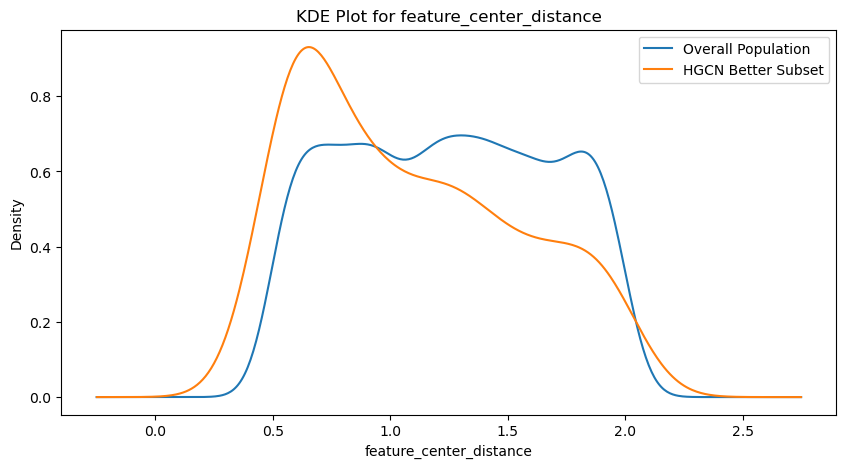

K-S Statistic: 0.1839
P-value: 0.0000
Conclusion: The distributions are significantly different (p < 0.05). ✅
----------------------------------------------------

----- Analyzing Metric: avg_cc -----


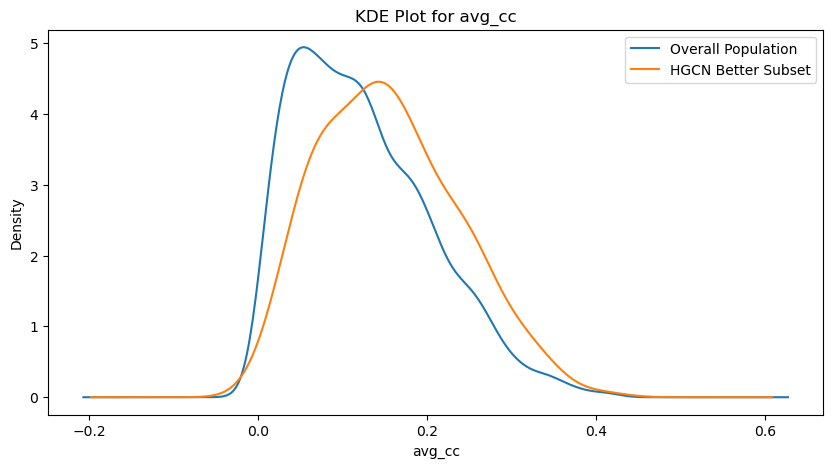

K-S Statistic: 0.1860
P-value: 0.0000
Conclusion: The distributions are significantly different (p < 0.05). ✅
-----------------------------------

----- Analyzing Metric: power_law_estimate -----


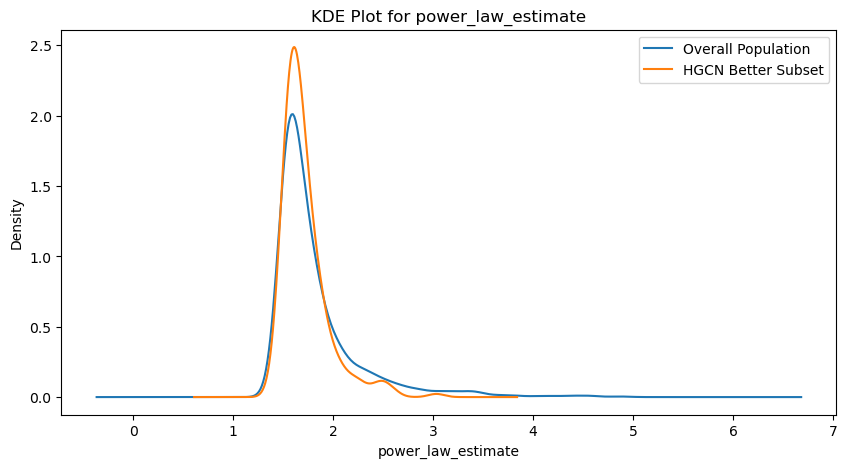

K-S Statistic: 0.1083
P-value: 0.0141
Conclusion: The distributions are significantly different (p < 0.05). ✅
-----------------------------------------------



In [104]:
from scipy.stats import kstest
hgcn_better_subset = df[df['perf_delta'] < -0.1]

print('Number of overall samples:', df.shape[0])
print('Number of samples where HGCN is better by .1:', df[df['perf_delta'] < -0.05].shape[0])

alpha = 0.05

for metric in graph_metrics_refined:
    print(f"----- Analyzing Metric: {metric} -----")

    # --- 1. Plotting (Your original logic) ---
    plt.figure(figsize=(10, 5))
    ax = df[metric].plot.kde(label='Overall Population', ind=500)
    hgcn_better_subset[metric].plot.kde(ax=ax, label='HGCN Better Subset', ind=500)
    plt.xlabel(metric)
    plt.title(f'KDE Plot for {metric}')
    plt.legend()
    plt.show()

    # --- 2. Statistical Test (K-S Test) ---
    # Prepare the two samples for comparison, dropping any potential NaNs
    sample1 = hgcn_better_subset[metric].dropna()
    sample2 = df[metric].dropna()

    # Perform the two-sample K-S test
    ks_statistic, p_value = kstest(sample1, sample2)

    # --- 3. Report Results ---
    print(f"K-S Statistic: {ks_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpret the result based on the significance level
    if p_value < alpha:
        print(f"Conclusion: The distributions are significantly different (p < {alpha}). ✅")
    else:
        print(f"Conclusion: We cannot conclude the distributions are different (p >= {alpha}). ❌")
    print("-" * (29 + len(metric)) + "\n")

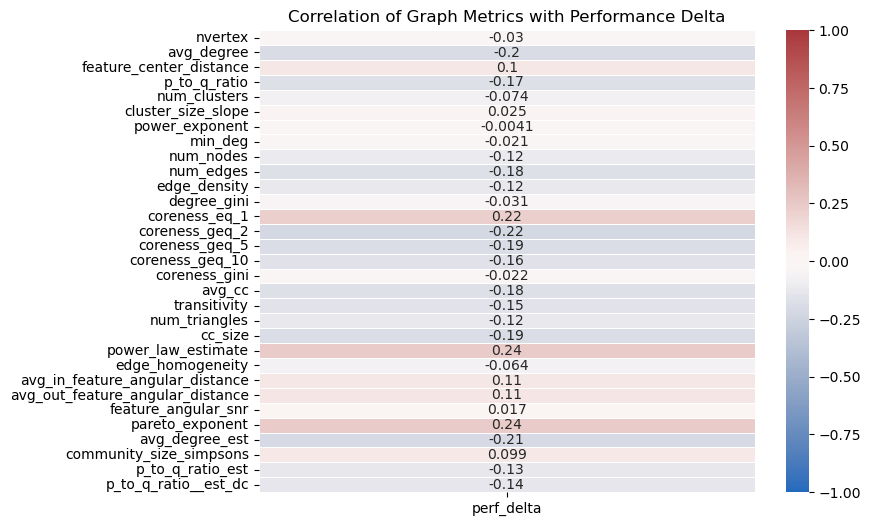


----- Generating Scatter Plots for Significant Metrics -----
Found 6 significant metrics: ['avg_degree', 'coreness_eq_1', 'coreness_geq_2', 'power_law_estimate', 'pareto_exponent', 'avg_degree_est']



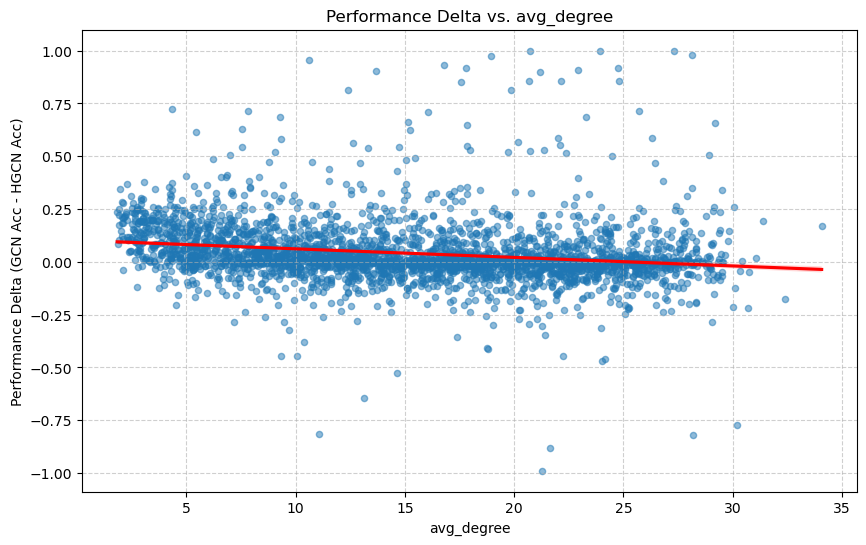

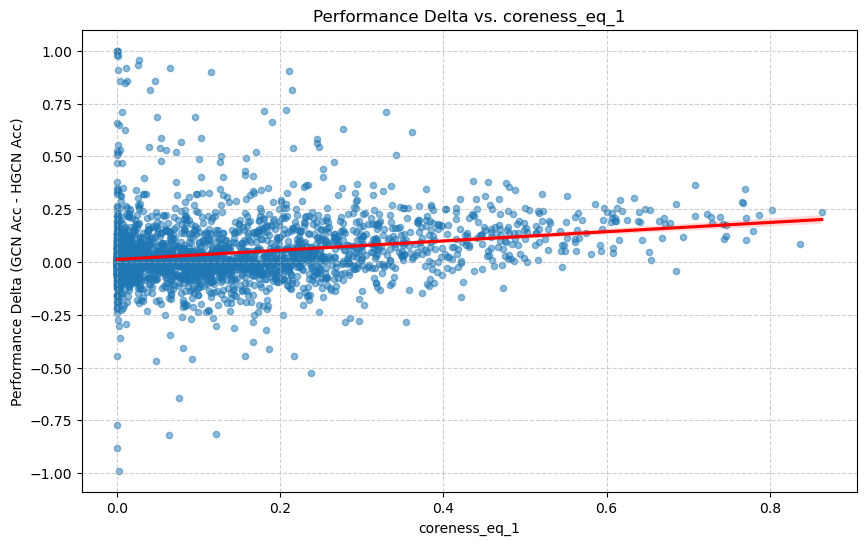

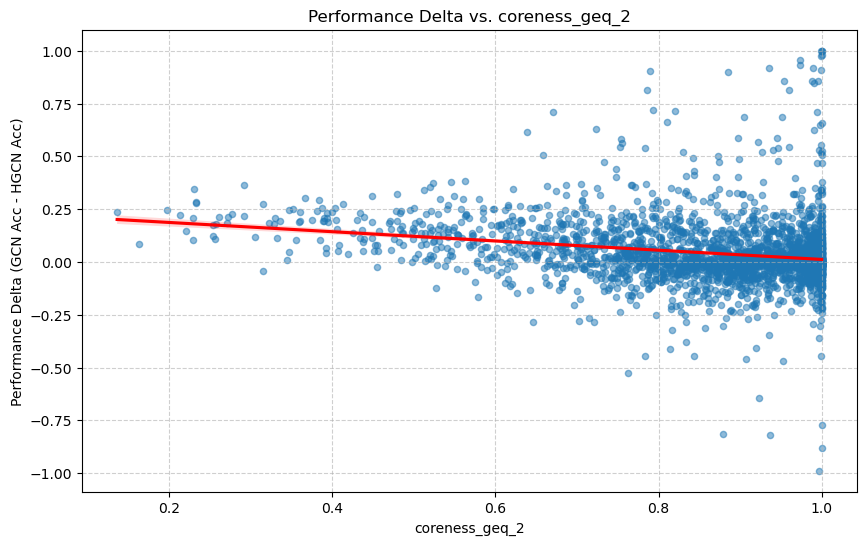

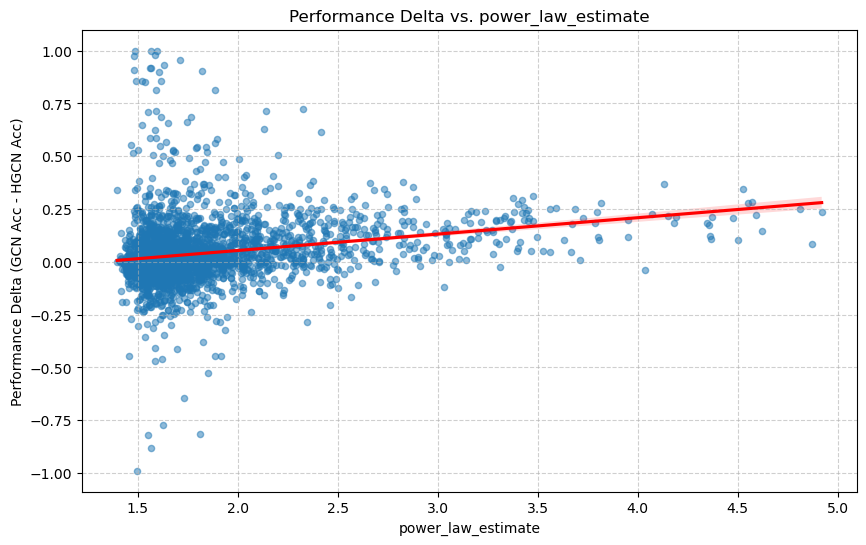

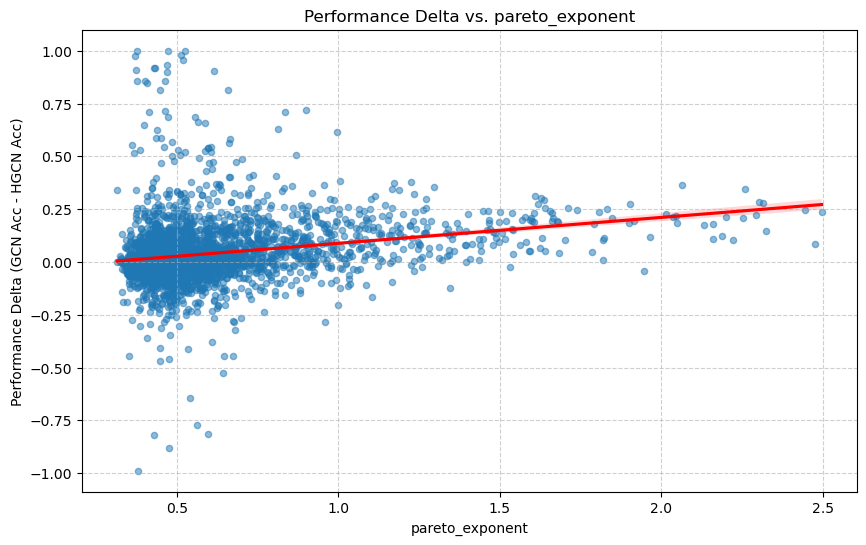

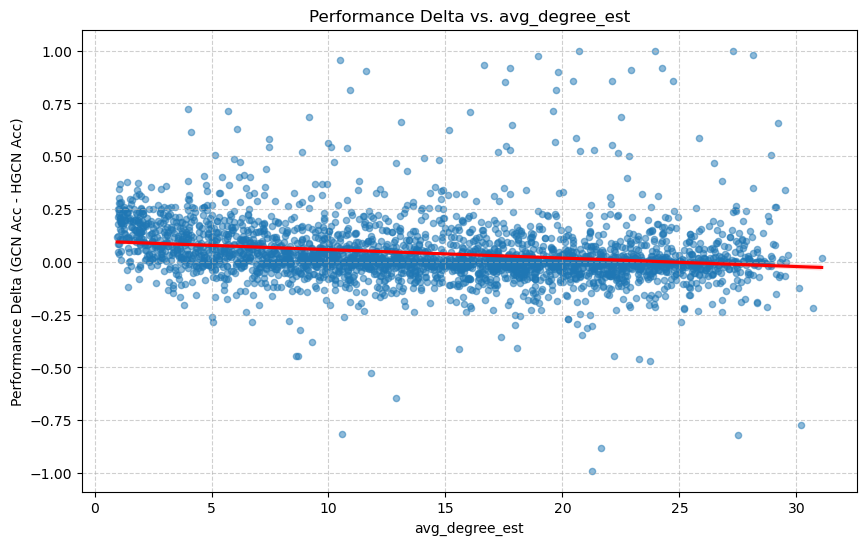

In [59]:
metrics_to_correlate = graph_metrics + ['perf_delta']
correlation_matrix = df[metrics_to_correlate].corr()

# Isolate the correlations with the performance delta for easier analysis
perf_delta_correlations = correlation_matrix[['perf_delta']].drop('perf_delta')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    perf_delta_correlations,
    annot=True,          # Display the correlation values on the map
    cmap='vlag',         # A divergent colormap is good for correlations (pos/neg)
    vmin=-1, vmax=1,     # Set the color scale from -1 to 1
    linewidths=.5
)
plt.title('Correlation of Graph Metrics with Performance Delta')
plt.show()


# --- 2. Scatter Plots for Significantly Correlated Metrics ---
print("\n----- Generating Scatter Plots for Significant Metrics -----")

# Define a threshold for what we consider a "significant" correlation
# This is a practical threshold, not a statistical one. Adjust as needed.
correlation_threshold = 0.2

# Find metrics that meet the threshold
significant_metrics = perf_delta_correlations[
    perf_delta_correlations['perf_delta'].abs() > correlation_threshold
].index.tolist()

if not significant_metrics:
    print("No metrics found with an absolute correlation greater than the threshold "
          f"of {correlation_threshold}.")
else:
    print(f"Found {len(significant_metrics)} significant metrics: {significant_metrics}\n")

    # Create a scatter plot for each significant metric
    for metric in significant_metrics:
        plt.figure(figsize=(10, 6))
        # Use seaborn's regplot to automatically add a regression line and confidence interval
        sns.regplot(
            data=df,
            x=metric,
            y='perf_delta',
            scatter_kws={'alpha': 0.5, 's': 20}, # Make points semi-transparent and smaller
            line_kws={'color': 'red'}           # Make the regression line red
        )
        plt.title(f'Performance Delta vs. {metric}')
        plt.xlabel(f'{metric}')
        plt.ylabel('Performance Delta (GCN Acc - HGCN Acc)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


In [121]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import optuna


print("----- Running Pre-flight Data Checks -----")
# Check for NaN values
nan_counts = df[graph_metrics + ['perf_delta']].isnull().sum()
print("NaN values found in columns:\n", nan_counts[nan_counts > 0])
inf_counts = df[graph_metrics + ['perf_delta']].apply(lambda col: np.isinf(col).sum())
print("\nInfinity values found in columns:\n", inf_counts[inf_counts > 0])
original_size = len(df)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=graph_metrics + ['perf_delta'], inplace=True)
print(f"\nDropped {original_size - len(df)} rows containing NaN or infinity values.")
print("-" * 42 + "\n")


df['class_target'] = np.where(df['perf_delta'] < 0, 1, 0)

X = df[graph_metrics_refined]
y = df['class_target']

# Split data once to get a final hold-out test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 1. Define the objective function for Optuna to optimize
def objective(trial):
    """
    This function takes a trial object and returns the score to be maximized.
    """
    # Define the hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42
    }
    
    # Handle class imbalance
    # This is a key parameter!
    ratio = (y_train == 0).sum() / (y_train == 1).sum()
    params['scale_pos_weight'] = trial.suggest_categorical('scale_pos_weight', [1, ratio])

    model = xgb.XGBClassifier(**params)
    
    # Use cross-validation for robust evaluation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    
    return score

# 2. Create and run the Optuna study
print("🔎 Starting hyperparameter tuning with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials

# 3. Print the best results
print("\n✨ Tuning complete!")
print(f"Best trial score (ROC AUC): {study.best_value:.4f}")
print("Best hyperparameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 4. Train the final model with the best hyperparameters
print("\n🚀 Training the final XGBoost model with best params...")
best_params = study.best_params
# Make sure to include the fixed parameters
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['random_state'] = 42

final_xgb = xgb.XGBClassifier(**best_params)
final_xgb.fit(X_train, y_train)
print("✅ Final model training complete.")

# 5. Evaluate the final model on the hold-out test set
y_pred = final_xgb.predict(X_test)
y_pred_proba = final_xgb.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n🎯 Final Model Accuracy on Test Set: {accuracy:.4f}")
print(f"🎯 Final Model ROC AUC on Test Set: {roc_auc:.4f}")
print("\n📊 Final Model Classification Report:")
print(classification_report(y_test, y_pred))

[I 2025-07-30 13:02:31,676] A new study created in memory with name: no-name-43b35372-d9a4-4681-91e0-d79557ee33df


----- Running Pre-flight Data Checks -----
NaN values found in columns:
 perf_delta    1
dtype: int64

Infinity values found in columns:
 Series([], dtype: int64)

Dropped 1 rows containing NaN or infinity values.
------------------------------------------

🔎 Starting hyperparameter tuning with Optuna...


[I 2025-07-30 13:02:34,825] Trial 0 finished with value: 0.7642012824954574 and parameters: {'n_estimators': 400, 'learning_rate': 0.008532639319247453, 'max_depth': 7, 'subsample': 0.6136130275251227, 'colsample_bytree': 0.9514220830352973, 'gamma': 2.339051176546347e-05, 'reg_alpha': 0.3829709049573221, 'reg_lambda': 3.2481028113543716e-05, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.7642012824954574.
[I 2025-07-30 13:02:37,243] Trial 1 finished with value: 0.7599638187979961 and parameters: {'n_estimators': 300, 'learning_rate': 0.0012990749204095508, 'max_depth': 7, 'subsample': 0.6640698501766433, 'colsample_bytree': 0.6277521312491073, 'gamma': 9.547754829201678e-08, 'reg_alpha': 0.0005627539682530427, 'reg_lambda': 0.0028604265131505807, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.7642012824954574.
[I 2025-07-30 13:02:45,765] Trial 2 finished with value: 0.7514051782324758 and parameters: {'n_estimators': 800, 'learning_rate': 0.025627308441860043, 'max_depth


✨ Tuning complete!
Best trial score (ROC AUC): 0.7691
Best hyperparameters found:
  n_estimators: 1000
  learning_rate: 0.0023274849709326337
  max_depth: 4
  subsample: 0.8457555716253655
  colsample_bytree: 0.9168028573424362
  gamma: 0.12759964016293343
  reg_alpha: 0.00030045885022857556
  reg_lambda: 0.0184415689345813
  scale_pos_weight: 1

🚀 Training the final XGBoost model with best params...
✅ Final model training complete.

🎯 Final Model Accuracy on Test Set: 0.6917
🎯 Final Model ROC AUC on Test Set: 0.7635

📊 Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       348
           1       0.62      0.67      0.65       252

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.70      0.69      0.69       600



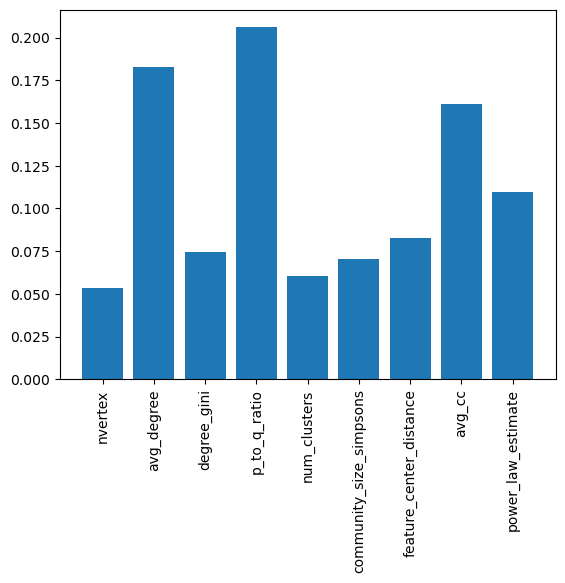

In [140]:
plt.bar(x = final_xgb.feature_names_in_, height = final_xgb.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

In [145]:
graph_metrics_refined

['nvertex',
 'avg_degree',
 'degree_gini',
 'p_to_q_ratio',
 'num_clusters',
 'community_size_simpsons',
 'feature_center_distance',
 'avg_cc',
 'power_law_estimate']

🌳 Training a shallow Decision Tree for interpretability...
✅ Tree training complete.
Accuracy 0.65
ROC AUC 0.7107906860062032
📊 Generating visualization...


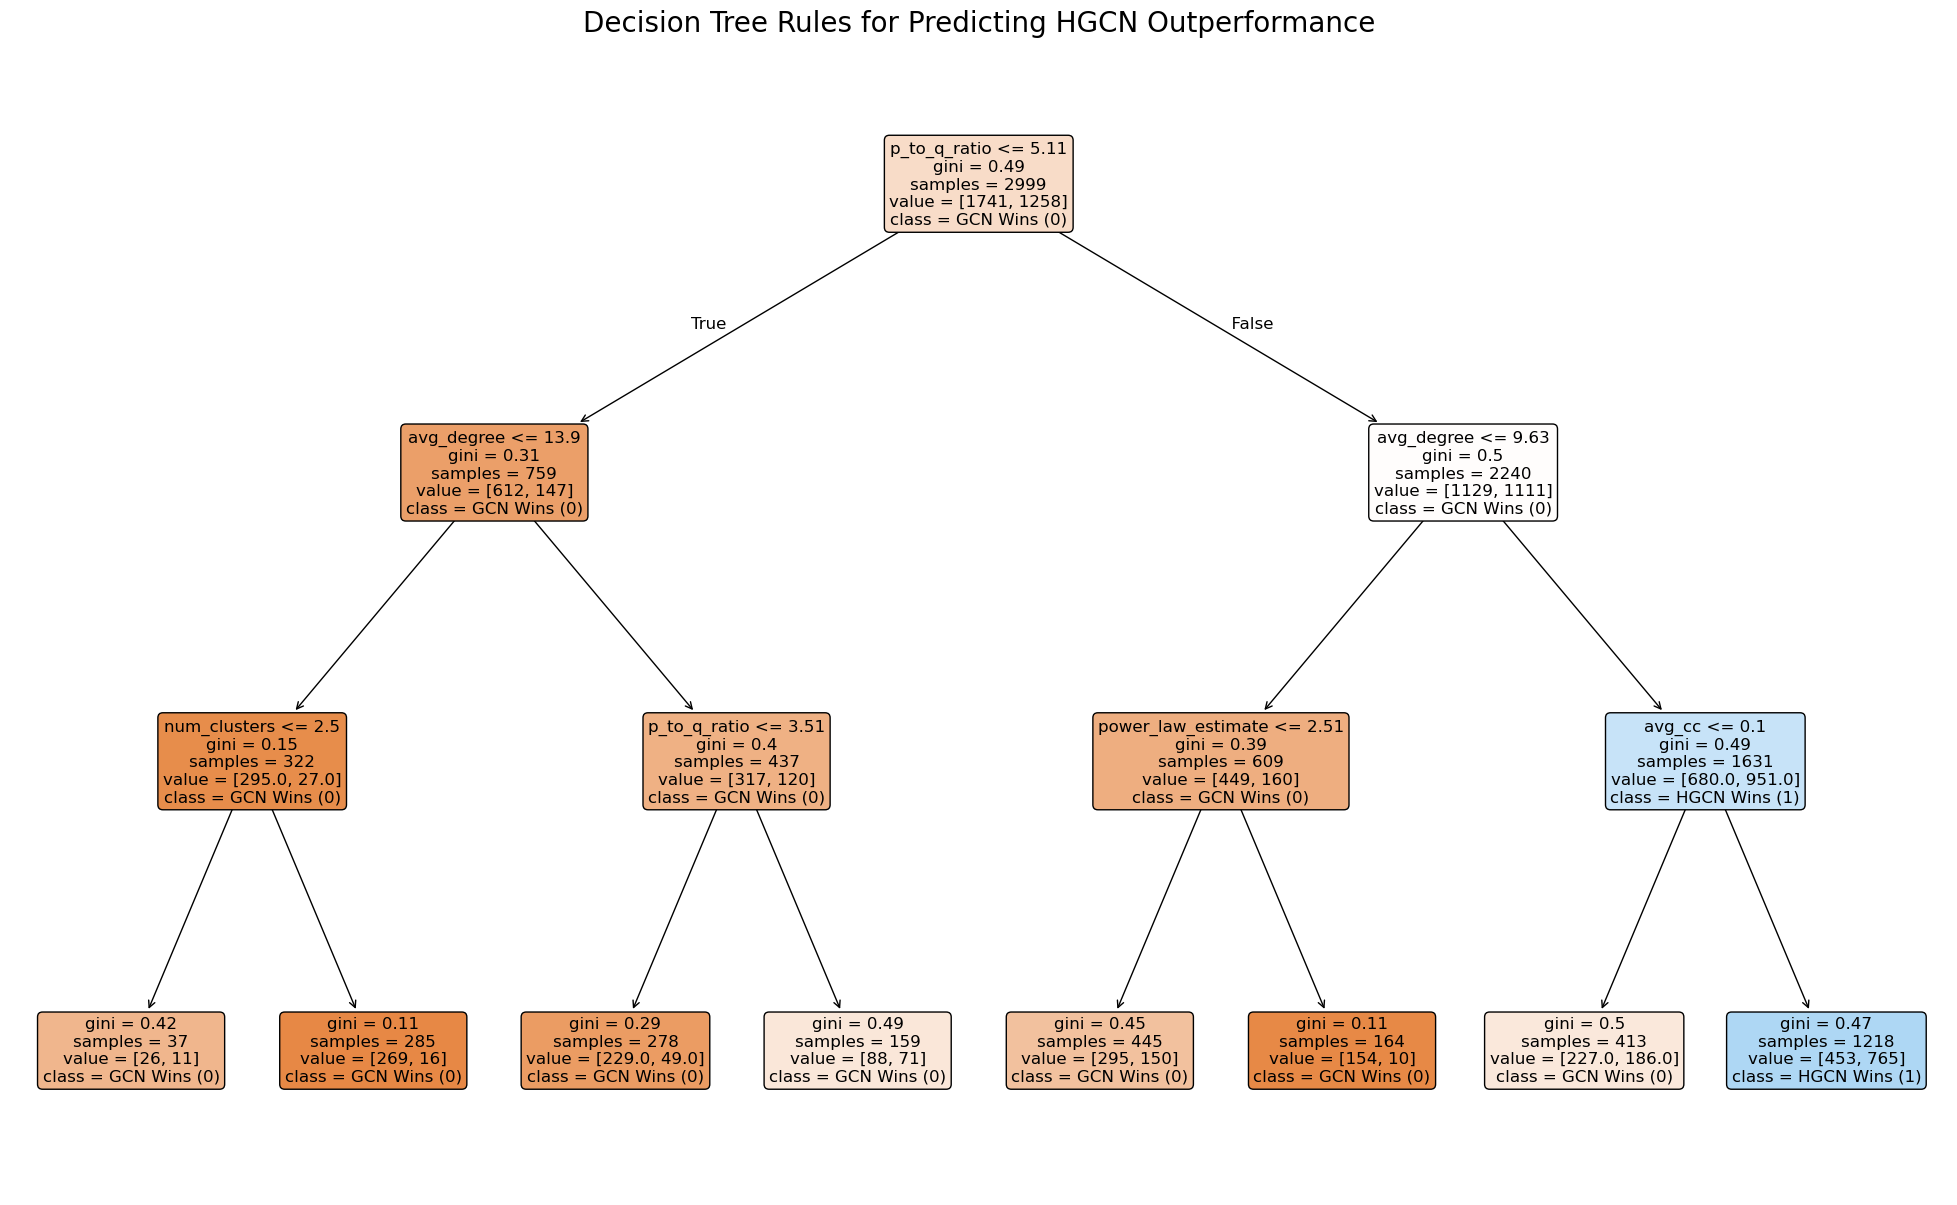

In [144]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

print("🌳 Training a shallow Decision Tree for interpretability...")
dt_classifier = DecisionTreeClassifier(
    max_depth=3,
    random_state=42,
    min_samples_leaf=20 # Prevents creating nodes for just a few samples
)
dt_classifier.fit(X, y)
print("✅ Tree training complete.")

print("Accuracy", accuracy)
print("ROC AUC", roc_auc)


# --- 3. Visualize the Tree ---
# The plot shows the rules the model learned.
print("📊 Generating visualization...")
plt.figure(figsize=(25, 15)) # Use a large figure size to make the text readable
plot_tree(
    dt_classifier,
    feature_names=X.columns.tolist(),
    class_names=['GCN Wins (0)', 'HGCN Wins (1)'], # Labels for the target classes
    filled=True,        # Color nodes by majority class
    rounded=True,       # Use rounded boxes
    fontsize=12,        # Adjust font size for readability
    precision=2         # Show values to 2 decimal places
)
plt.title("Decision Tree Rules for Predicting HGCN Outperformance", fontsize=20)
plt.show()

📊 Generating scatter plot for the 2240 samples where p_to_q_ratio > 5.11...


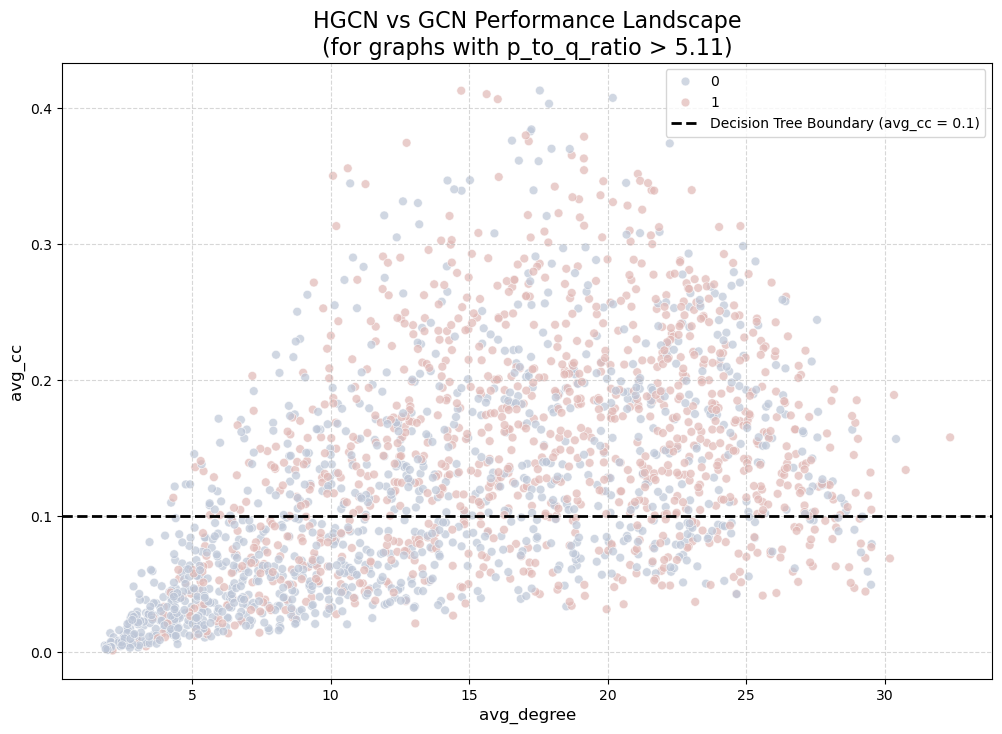

In [147]:
feature1 = 'avg_degree'
feature2 = 'avg_cc'

plot_df = df[df['p_to_q_ratio'] > 5.11].copy()

print(f"📊 Generating scatter plot for the {len(plot_df)} samples where p_to_q_ratio > 5.11...")
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=plot_df,
    x=feature1,
    y=feature2,
    hue='class_target',   # Color each point by the continuous performance delta
    palette='vlag',     # A divergent Red-White-Blue colormap. Blue = HGCN wins.
    alpha=0.7,
    s=40                # Size of the points
)

# We can add a line to show where the decision tree made its split
# This helps connect the two analyses
plt.axhline(y=0.1, color='black', linestyle='--', linewidth=2, label='Decision Tree Boundary (avg_cc = 0.1)')


# --- 4. Customize and Show the Plot ---
plt.title(f'HGCN vs GCN Performance Landscape\n(for graphs with p_to_q_ratio > 5.11)', fontsize=16)
plt.xlabel(feature1, fontsize=12)
plt.ylabel(feature2, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

✅ SHAP values calculated.


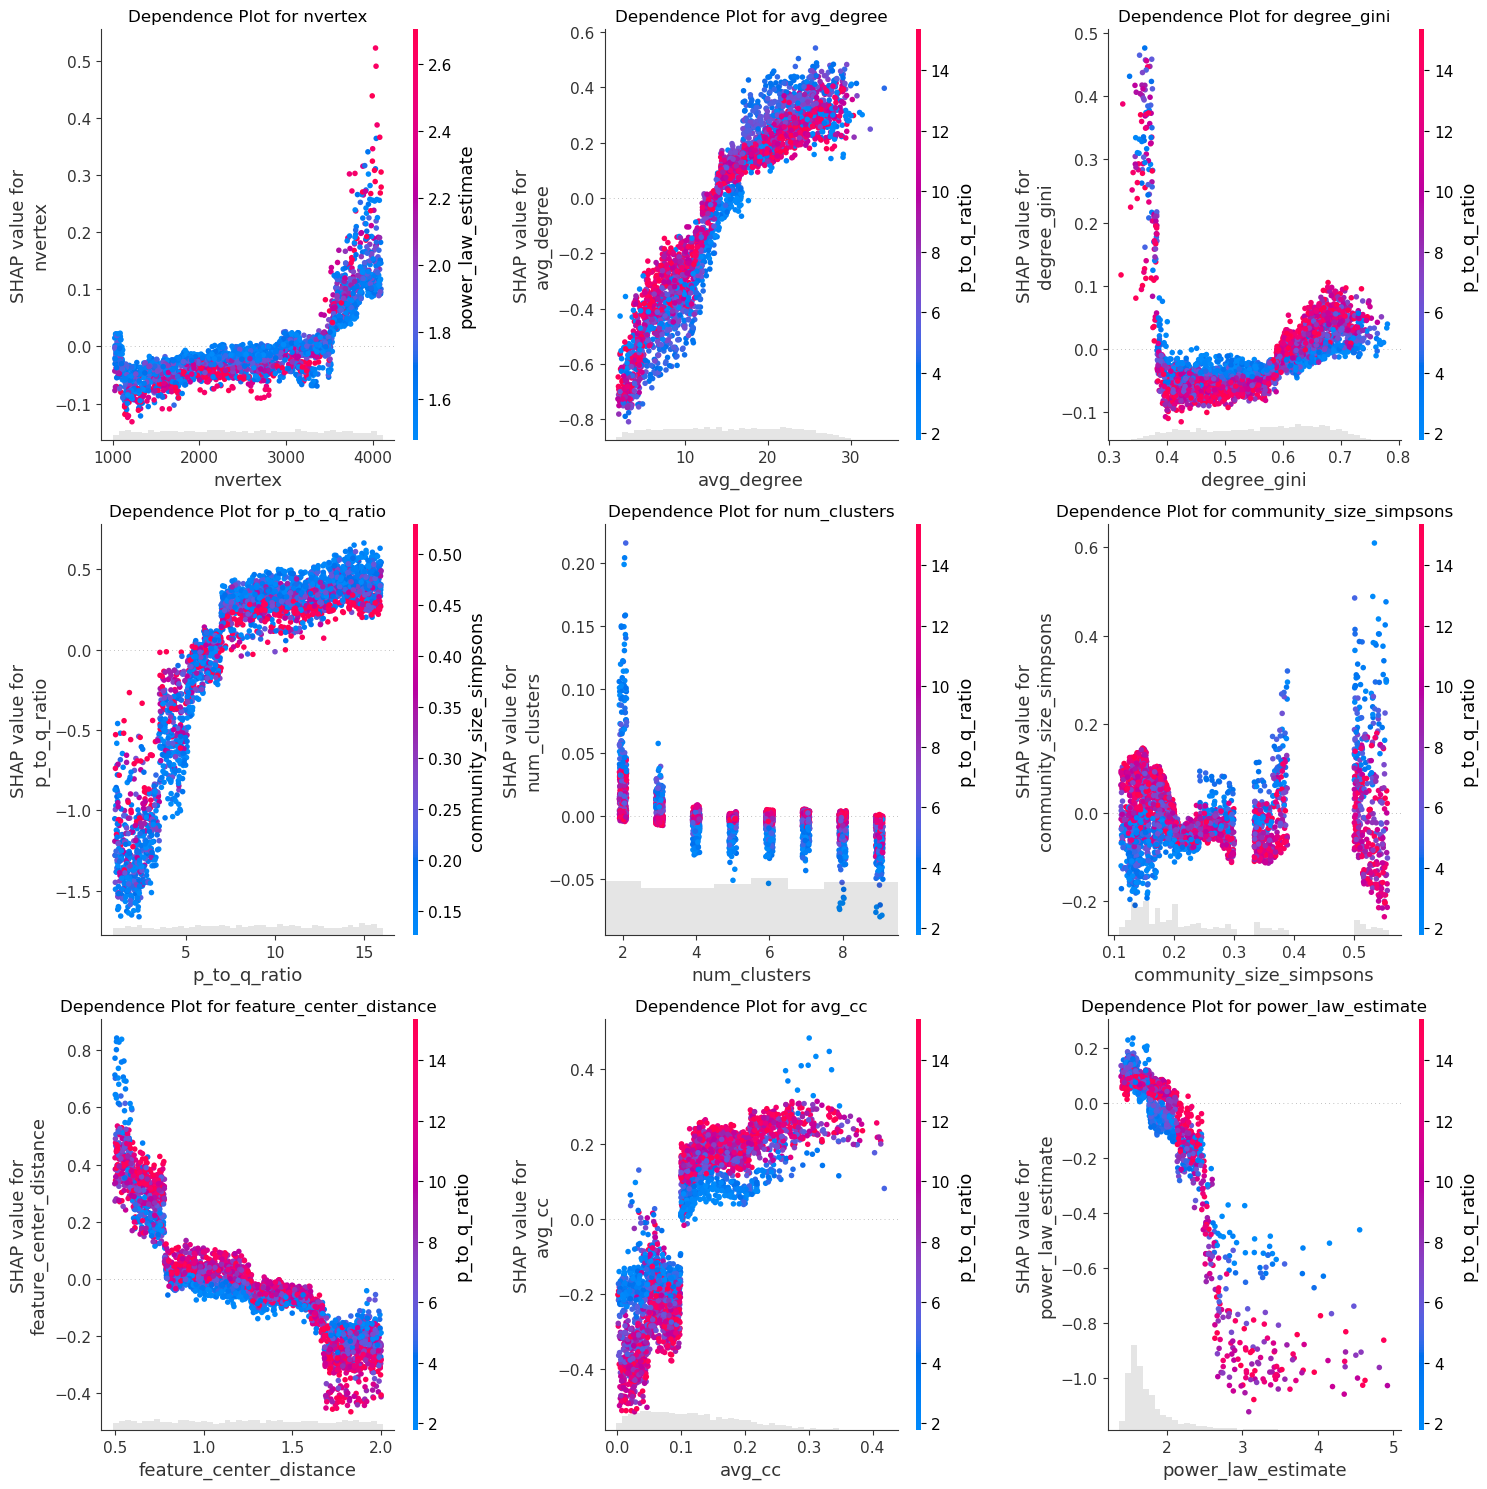

In [157]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer(X) # Using the explainer as a function is the modern API
print("✅ SHAP values calculated.")


# --- 2. Set up the Matplotlib Subplot Grid ---
num_features = len(graph_metrics_refined)
# Define a 2-column layout
ncols = 3
nrows = math.ceil(num_features / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
# Flatten the axes array for easy iteration, and handle odd numbers of plots
axes = axes.flatten()

for i, metric in enumerate(graph_metrics_refined):
    ax = axes[i]
    # Use the lower-level shap.plots.scatter function which accepts an axis object
    shap.plots.scatter(
        shap_values[:, metric],
        color=shap_values, # Automatically pick the best interaction feature for color
        ax=ax,
        show=False # Important: Do not show the plot yet
    )
    ax.set_title(f"Dependence Plot for {metric}", fontsize=12)

# Hide any unused subplots if the number of features is odd
if num_features < len(axes):
    for j in range(num_features, len(axes)):
        axes[j].axis('off')

# --- 4. Finalize and Show the Grid ---
plt.tight_layout() # Adjusts subplot params for a tight layout.
plt.show()